In [1]:
#Load all necessary libraries

import os, re
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup

In [2]:
#Derive the path of the files containing the data

p = os.getcwd()
par = os.path.abspath(os.path.join(p, os.pardir))
data_path = os.path.join(par, 'Data/archive')

qfile = os.path.join(data_path, 'Questions.csv')
tfile = os.path.join(data_path, 'Tags.csv')

In [3]:
#Read and store data in pandas dataframes

questions = pd.read_csv(qfile, encoding = "ISO-8859-1")
questions = questions.drop(['Score', 'OwnerUserId', 'CreationDate', 'ClosedDate'], axis=1)
tags = pd.read_csv(tfile, encoding = "ISO-8859-1")

In [4]:
questions.head()

,Id,Title,Body
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [5]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [6]:
print(questions.shape)

(1264216, 3)


In [7]:
print(tags.shape)

(3750994, 2)


## Inspection of tags with respect to the times identified in the dataset

In [8]:
#Number of unique tags over all the dataset

un_tags = pd.unique(tags['Tag'])
print(un_tags.shape)

(37035,)


In [9]:
comm = collections.Counter(list(tags['Tag'])).most_common(50)
print(comm)

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009), ('mysql', 42464), ('css', 42308), ('sql', 35782), ('asp.net', 29970), ('objective-c', 26922), ('ruby-on-rails', 25789), ('.net', 24059), ('c', 23238), ('iphone', 21539), ('angularjs', 20345), ('arrays', 19799), ('sql-server', 18160), ('json', 17669), ('ruby', 17013), ('r', 15701), ('ajax', 15629), ('regex', 15349), ('xml', 14763), ('node.js', 14525), ('asp.net-mvc', 14284), ('linux', 13395), ('django', 12818), ('wpf', 12365), ('database', 11860), ('swift', 11832), ('xcode', 10633), ('string', 10427), ('excel', 10384), ('vb.net', 10286), ('windows', 10142), ('spring', 9935), ('wordpress', 9913), ('eclipse', 9895), ('html5', 9564), ('multithreading', 9006), ('oracle', 7645), ('git', 7626), ('facebook', 7598), ('forms', 7588), ('bash', 7484)]


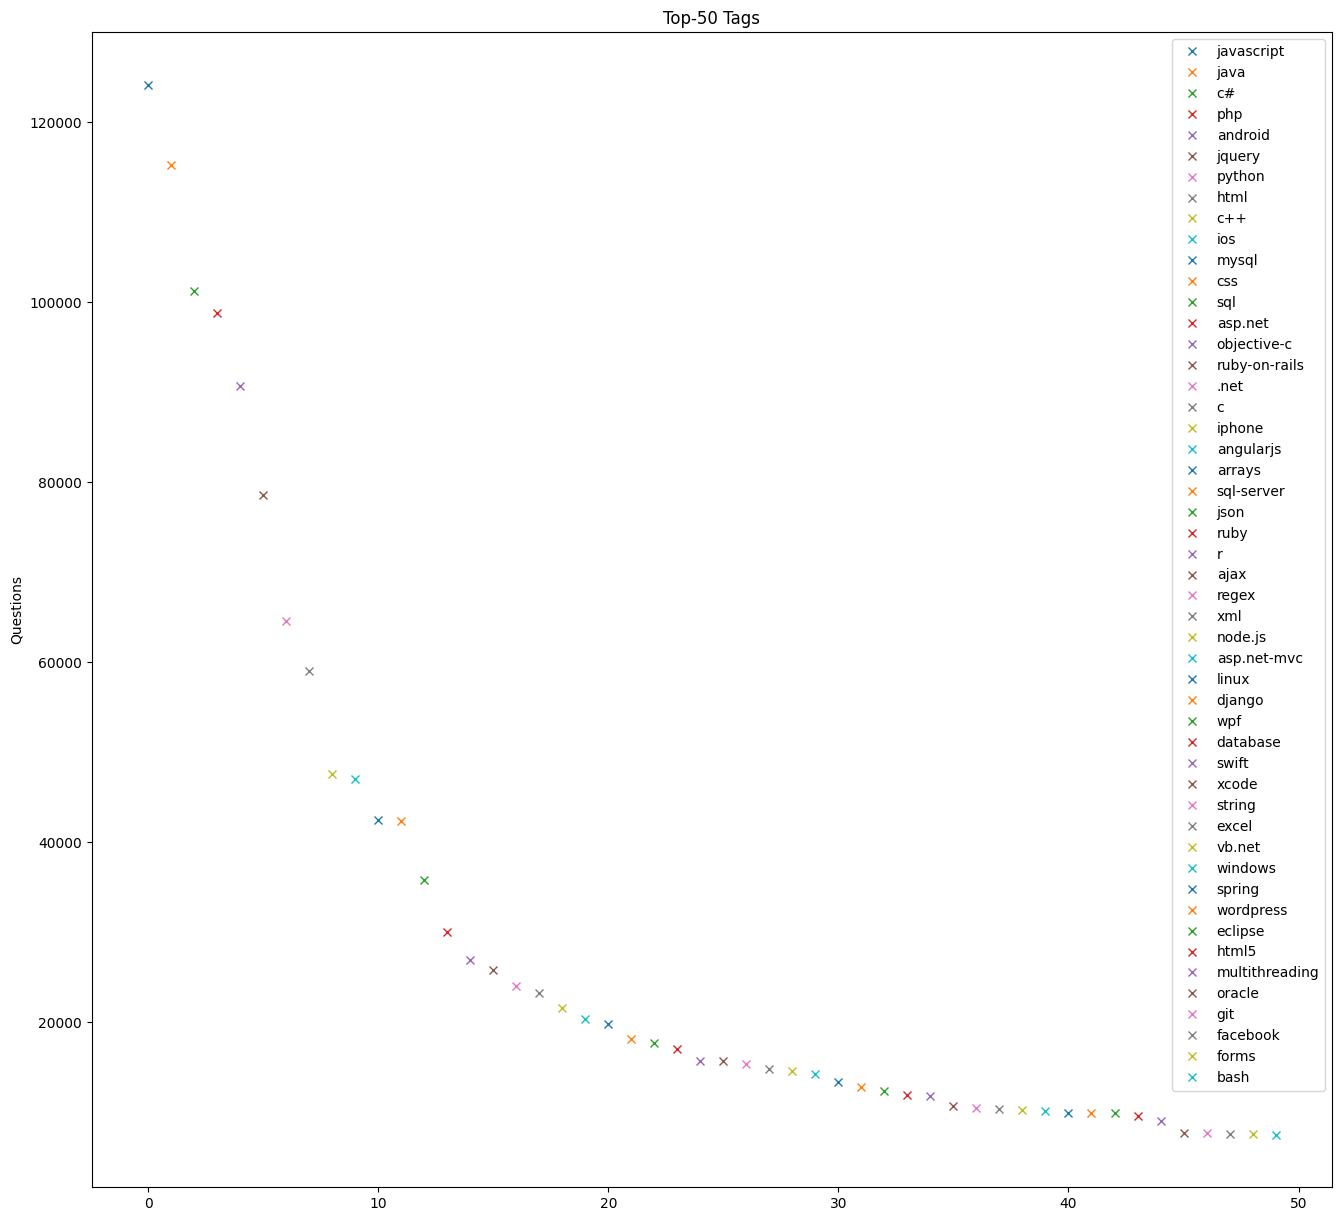

In [10]:
x, y = zip(*comm)

plt.figure(figsize=(16, 15))
plt.ylabel("Questions")
plt.title("Top-50 Tags")

for i in range(len(y)):
    plt.plot(i,y[i],marker='x',linestyle='',label=x[i])       
    
plt.legend(numpoints=1)
plt.show()

In [11]:
data_tags = pd.DataFrame(comm, columns =['Tag', 'Questions'])
print(data_tags)

               Tag  Questions
0       javascript     124155
1             java     115212
2               c#     101186
3              php      98808
4          android      90659
5           jquery      78542
6           python      64601
7             html      58976
8              c++      47591
9              ios      47009
10           mysql      42464
11             css      42308
12             sql      35782
13         asp.net      29970
14     objective-c      26922
15   ruby-on-rails      25789
16            .net      24059
17               c      23238
18          iphone      21539
19       angularjs      20345
20          arrays      19799
21      sql-server      18160
22            json      17669
23            ruby      17013
24               r      15701
25            ajax      15629
26           regex      15349
27             xml      14763
28         node.js      14525
29     asp.net-mvc      14284
30           linux      13395
31          django      12818
32        

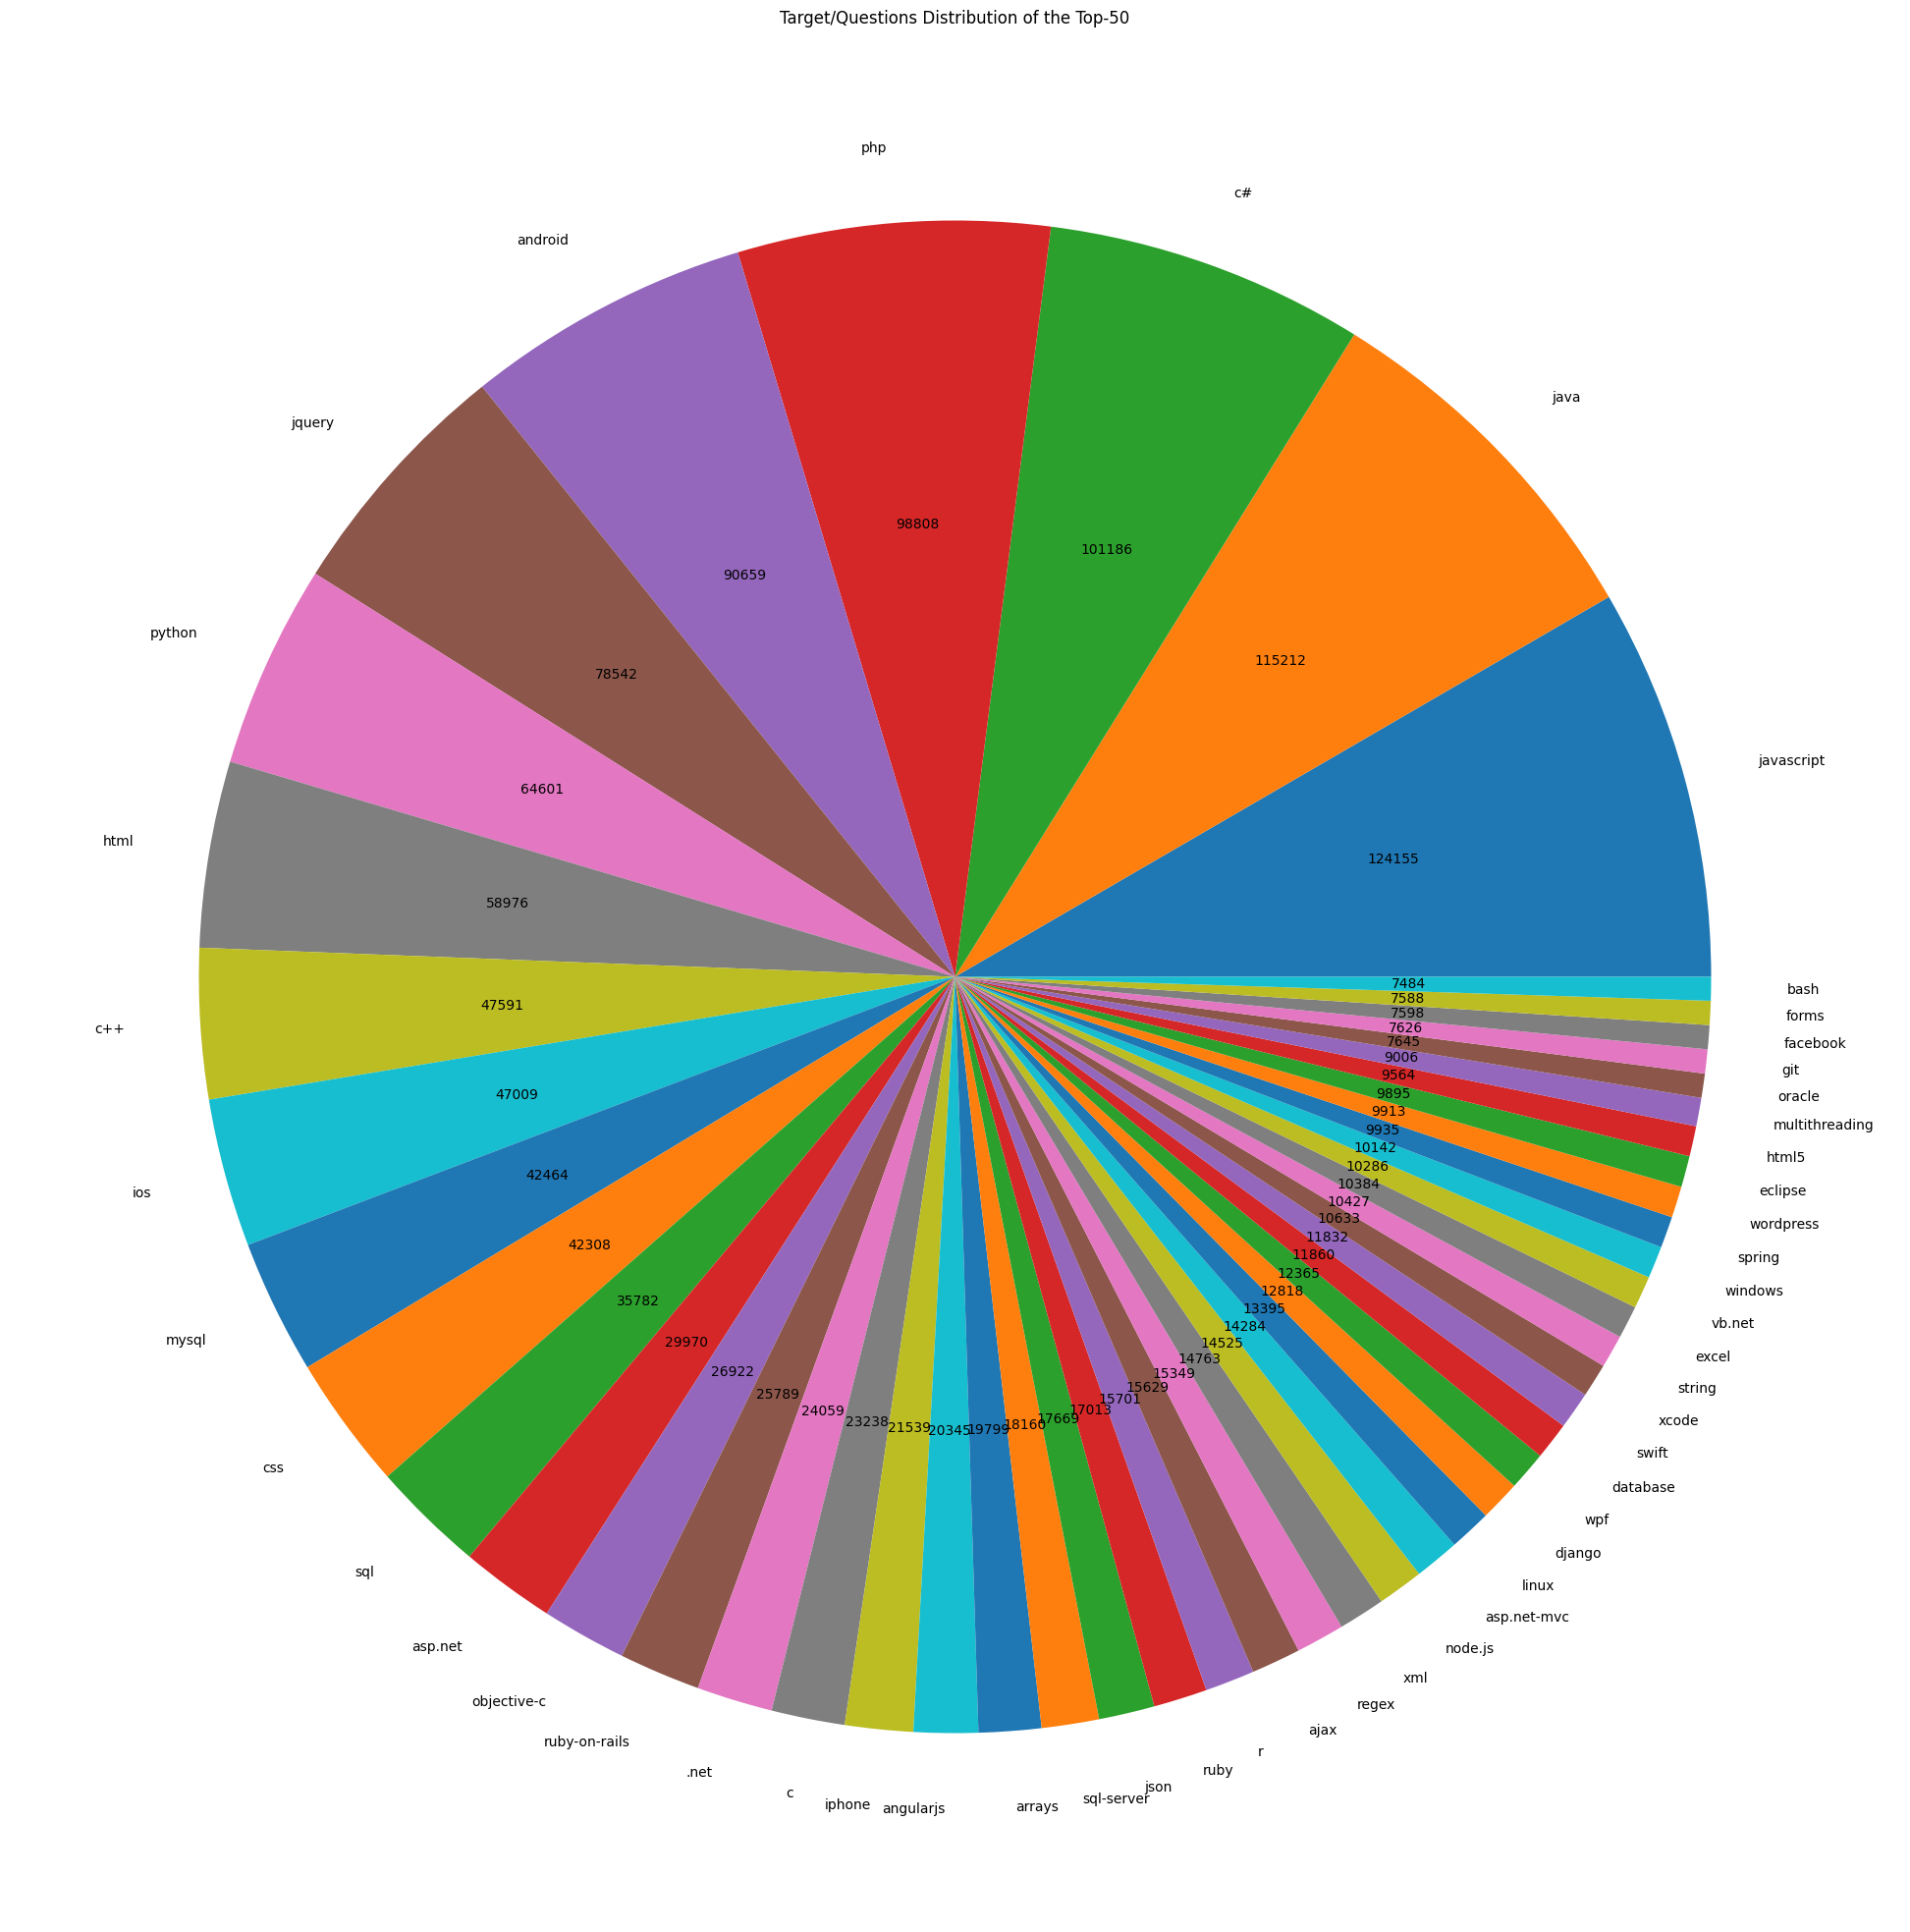

In [12]:
plt.figure(figsize=(25, 25))

p, tx, autotexts = plt.pie(x=data_tags['Questions'], labels=data_tags['Tag'], autopct=" ")

for i, a in enumerate(autotexts):
    a.set_text("{}".format(data_tags['Questions'][i]))

plt.title("Target/Questions Distribution of the Top-50")
plt.show()

In [13]:
#When keeping the top 50 tags we have managed to get almost the 40% of the overall dataset.

data_tags['Questions'].sum()/tags.shape[0] * 100

39.52133754412831

## Inspection of the data regarding how many labels each question has

In [14]:
#We should change all capital letters and remove any characters that will confuse our model

def clean_text(text):
    text = text.lower()
    #text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text

In [15]:
questions['Body'] = questions['Body'].apply(clean_text)
questions['Title'] = questions['Title'].apply(clean_text)

In [16]:
questions.head()

,Id,Title,Body
0,80,sqlstatement.execute() - multiple queries in o...,<p>i've written a database generation script i...
1,90,good branching and merging tutorials for torto...,<p>are there any really good tutorials explain...
2,120,asp.net site maps,<p>has anyone got experience creating <strong>...
3,180,function for creating color wheels,<p>this is something i've pseudo-solved many t...
4,260,adding scripting functionality to .net applica...,<p>i have a little game written in c#. it uses...


In [17]:
tags['Tag'] = tags['Tag'].astype(str).apply(clean_text)

In [18]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [19]:
#Multiple tags will go in one row

tags_per_quest = tags.groupby(['Id'])['Tag'].apply(list)

In [20]:
#We will now merge the tags based on the 'Id'

data = questions.merge(tags_per_quest.to_frame(), on="Id")

In [21]:
data.head()

,Id,Title,Body,Tag
0,80,sqlstatement.execute() - multiple queries in o...,<p>i've written a database generation script i...,"[flex, actionscript-3, air]"
1,90,good branching and merging tutorials for torto...,<p>are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,120,asp.net site maps,<p>has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,180,function for creating color wheels,<p>this is something i've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,260,adding scripting functionality to .net applica...,<p>i have a little game written in c#. it uses...,"[c#, .net, scripting, compiler-construction]"


In [22]:
print(data.shape)

(1264216, 4)


In [23]:
data["NoTags"] = data["Tag"].apply(len)

In [24]:
data.head()

,Id,Title,Body,Tag,NoTags
0,80,sqlstatement.execute() - multiple queries in o...,<p>i've written a database generation script i...,"[flex, actionscript-3, air]",3
1,90,good branching and merging tutorials for torto...,<p>are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",4
2,120,asp.net site maps,<p>has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",3
3,180,function for creating color wheels,<p>this is something i've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",4
4,260,adding scripting functionality to .net applica...,<p>i have a little game written in c#. it uses...,"[c#, .net, scripting, compiler-construction]",4


In [25]:
stats = data['NoTags'].value_counts(sort=False, ascending=False)
stats_sort = stats.sort_index()
stats_sort

NoTags
1    150028
2    326804
3    367669
4    254224
5    165491
Name: count, dtype: int64

<BarContainer object of 5 artists>

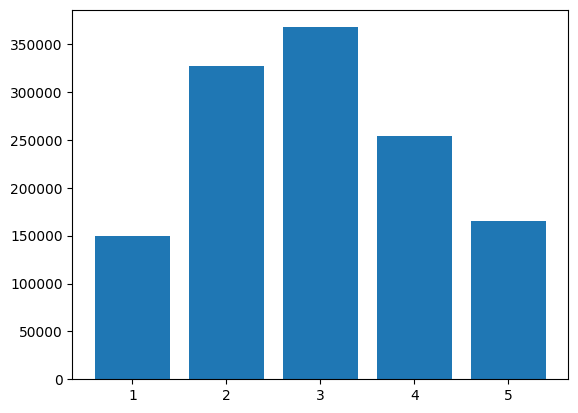

In [26]:
plt.bar(stats.index, stats)

##### As observed, most comments have 3 tags, yet the least is 1 tag and the most is 5 tags

In [30]:
# We will save our 'data' in a pickle file for the following usages

data.to_pickle('data.pkl')
data.dtypes

Id         int64
Title     object
Body      object
Tag       object
NoTags     int64
dtype: object

## Remove HTML components, words not necessary and split the sentences in words

In [2]:
data = pd.read_pickle('data.pkl')
data.head()

,Id,Title,Body,Tag,NoTags
0,80,sqlstatement.execute() - multiple queries in o...,<p>i've written a database generation script i...,"[flex, actionscript-3, air]",3
1,90,good branching and merging tutorials for torto...,<p>are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",4
2,120,asp.net site maps,<p>has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",3
3,180,function for creating color wheels,<p>this is something i've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",4
4,260,adding scripting functionality to .net applica...,<p>i have a little game written in c#. it uses...,"[c#, .net, scripting, compiler-construction]",4


In [8]:
#nltk.download('punkt')
tqdm.pandas()

# Firstly we remove any components from HTML 
data["Body"] = data["Body"].progress_apply(lambda text: BeautifulSoup(text, "html.parser").text)

# We have to be careful when cleaning our data mainly because either the title or the body might include
# characters that simple regex procedures will fail

combined = ["c#", "c++", ".net", "asp.net", "node.js", "objective-c", "unity3d", "html5", "css3", \
                       "ruby-on-rails", "utf-8", "scikit-learn", "x86", "asp.net-mvc"]


data["Body_token"] = data["Body"].progress_apply(lambda text: [word for word in nltk.word_tokenize(text) \
                                                               if word.isalpha() or word in list("+#") + combined])

  0%|          | 0/1264216 [00:00<?, ?it/s]

  0%|          | 0/1264216 [00:00<?, ?it/s]

In [9]:
# Now we want to keep significant words correctly

mwe_tokenizer = nltk.MWETokenizer(separator="")
mwe_tokenizer.add_mwe(("c", "#"))
mwe_tokenizer.add_mwe(("c", "+", "+"))

data["Body_token"] = data["Body_token"].progress_apply(lambda tokens: [token for token in mwe_tokenizer.tokenize(tokens)])

  0%|          | 0/1264216 [00:00<?, ?it/s]

In [10]:
data.head()

,Id,Title,Body,Tag,NoTags,Body_token
0,80,sqlstatement.execute() - multiple queries in o...,i've written a database generation script in s...,"[flex, actionscript-3, air]",3,"[i, written, a, database, generation, script, ..."
1,90,good branching and merging tutorials for torto...,are there any really good tutorials explaining...,"[svn, tortoisesvn, branch, branching-and-merging]",4,"[are, there, any, really, good, tutorials, exp..."
2,120,asp.net site maps,has anyone got experience creating sql-based a...,"[sql, asp.net, sitemap]",3,"[has, anyone, got, experience, creating, asp.n..."
3,180,function for creating color wheels,this is something i've pseudo-solved many time...,"[algorithm, language-agnostic, colors, color-s...",4,"[this, is, something, i, many, times, and, nev..."
4,260,adding scripting functionality to .net applica...,i have a little game written in c#. it uses a ...,"[c#, .net, scripting, compiler-construction]",4,"[i, have, a, little, game, written, in, c#, it..."


In [ ]:
data.to_pickle('data_body_tokenized.pkl')

### Save a file with the changes up to this point, and have a backup

In [2]:
data = pd.read_pickle('data_body_tokenized.pkl')
data.head()

,Id,Title,Body,Tag,NoTags,Body_token
0,80,sqlstatement.execute() - multiple queries in o...,i've written a database generation script in s...,"[flex, actionscript-3, air]",3,"[i, written, a, database, generation, script, ..."
1,90,good branching and merging tutorials for torto...,are there any really good tutorials explaining...,"[svn, tortoisesvn, branch, branching-and-merging]",4,"[are, there, any, really, good, tutorials, exp..."
2,120,asp.net site maps,has anyone got experience creating sql-based a...,"[sql, asp.net, sitemap]",3,"[has, anyone, got, experience, creating, asp.n..."
3,180,function for creating color wheels,this is something i've pseudo-solved many time...,"[algorithm, language-agnostic, colors, color-s...",4,"[this, is, something, i, many, times, and, nev..."
4,260,adding scripting functionality to .net applica...,i have a little game written in c#. it uses a ...,"[c#, .net, scripting, compiler-construction]",4,"[i, have, a, little, game, written, in, c#, it..."


In [3]:
data.shape

(1264216, 6)

In [4]:
# Let's remove any stopwords from the body of the question

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def filter_stop_words(words):
    words_filtered = []
    for word in words:
        if word not in stop_words:
            words_filtered.append(word)
    return words_filtered

In [5]:
tqdm.pandas()

data["Body_token"] = data["Body_token"].progress_apply(filter_stop_words)

  0%|          | 0/1264216 [00:00<?, ?it/s]

In [6]:
data.head()

,Id,Title,Body,Tag,NoTags,Body_token
0,80,sqlstatement.execute() - multiple queries in o...,i've written a database generation script in s...,"[flex, actionscript-3, air]",3,"[written, database, generation, script, sql, w..."
1,90,good branching and merging tutorials for torto...,are there any really good tutorials explaining...,"[svn, tortoisesvn, branch, branching-and-merging]",4,"[really, good, tutorials, explaining, branchin..."
2,120,asp.net site maps,has anyone got experience creating sql-based a...,"[sql, asp.net, sitemap]",3,"[anyone, got, experience, creating, asp.net, p..."
3,180,function for creating color wheels,this is something i've pseudo-solved many time...,"[algorithm, language-agnostic, colors, color-s...",4,"[something, many, times, never, quite, found, ..."
4,260,adding scripting functionality to .net applica...,i have a little game written in c#. it uses a ...,"[c#, .net, scripting, compiler-construction]",4,"[little, game, written, c#, uses, database, tr..."


In [7]:
# We repeat the procedure for the titles

combined = ["c#", "c++", ".net", "asp.net", "node.js", "objective-c", "unity3d", "html5", "css3", \
                       "ruby-on-rails", "utf-8", "scikit-learn", "x86", "asp.net-mvc"]

data["Title_token"] = data["Title"].progress_apply(lambda text: [word for word in nltk.word_tokenize(text) \
                                                               if word.isalpha() or word in list("+#") + combined])

  0%|          | 0/1264216 [00:00<?, ?it/s]

In [8]:
mwe_tokenizer = nltk.MWETokenizer(separator="")
mwe_tokenizer.add_mwe(("c", "#"))
mwe_tokenizer.add_mwe(("c", "+", "+"))

data["Title_token"] = data["Title_token"].progress_apply(lambda tokens: [token for token in mwe_tokenizer.tokenize(tokens)])

data["Title_token"] = data["Title_token"].progress_apply(filter_stop_words)

  0%|          | 0/1264216 [00:00<?, ?it/s]

  0%|          | 0/1264216 [00:00<?, ?it/s]

In [10]:
data.sample(10)

,Id,Title,Body,Tag,NoTags,Body_token,Title_token
917117,30606450,mule avoid downloading file after db select st...,"<flow name=""testflow1"" doc:name=""testflow1"">\n...",[mule],1,"[flow, doc, http, hostname, port, dbtest, doc,...","[mule, avoid, downloading, file, db, select, s..."
361818,12916830,android how to properly set default language f...,"i'm quite new to android dev, and i have a lit...","[android, localization, locale, android-prefer...",4,"[quite, new, android, dev, little, problem, lo...","[android, properly, set, default, language, ap..."
904944,30237880,aem cq5 move option for a file to another loca...,i have website configured in cq5 aem. i am try...,"[file, adobe, aem]",3,"[website, configured, aem, trying, move, files...","[aem, move, option, file, another, location]"
299807,10897530,is there a way to compare two richtextboxs tex...,i have two richtextbox's that display stored p...,"[c#, comparison, compare, richtextbox, highlig...",5,"[two, richtextbox, display, stored, procedures...","[way, compare, two, richtextboxs, text, highli..."
1098762,35796370,unable to select a dropdown value on grid data...,we have an application where we need to upload...,"[asp.net, gridview]",2,"[application, need, upload, data, excel, stage...","[unable, select, dropdown, value, grid, data, ..."
775450,26225670,zoom in ggplot after creating / reviewing,i'm making plots in batch mode. while reviewi...,"[r, ggplot2, zoom]",3,"[making, plots, batch, mode, reviewing, graphs...","[zoom, ggplot, creating, reviewing]"
918539,30649500,loop through ids with jquery and make them dro...,i've got a container #itemgrid and a few child...,"[javascript, jquery, loops]",3,"[got, container, #, itemgrid, unique, code, fa...","[loop, ids, jquery, make, droppable]"
920576,30709860,"shared_ptr: ""is not a type"" error",i created a simple program to test smart point...,"[c++, shared-ptr]",2,"[created, simple, program, test, smart, pointe...","[type, error]"
940426,31310070,does secure gateway client support self-signed...,i set up secure gateway's destination with htt...,"[ibm-bluemix, secure-gateway]",2,"[set, secure, gateway, destination, https, opt...","[secure, gateway, client, support, cert, cn, i..."
1034015,34028620,samsung internet browser causing issues with f...,i am having a weird problem with @font-face an...,"[svg, cross-browser, font-face, android-browser]",4,"[weird, problem, svg, images, specifically, sa...","[samsung, internet, browser, causing, issues, ..."


In [14]:
tokenized_data = data[['Id', 'Title_token', 'Body_token', 'Tag']]

In [15]:
tokenized_data.shape

(1264216, 4)

In [16]:
tokenized_data.head()

,Id,Title_token,Body_token,Tag
0,80,"[multiple, queries, one, statement]","[written, database, generation, script, sql, w...","[flex, actionscript-3, air]"
1,90,"[good, branching, merging, tutorials, tortoise...","[really, good, tutorials, explaining, branchin...","[svn, tortoisesvn, branch, branching-and-merging]"
2,120,"[asp.net, site, maps]","[anyone, got, experience, creating, asp.net, p...","[sql, asp.net, sitemap]"
3,180,"[function, creating, color, wheels]","[something, many, times, never, quite, found, ...","[algorithm, language-agnostic, colors, color-s..."
4,260,"[adding, scripting, functionality, .net, appli...","[little, game, written, c#, uses, database, tr...","[c#, .net, scripting, compiler-construction]"


In [17]:
tokenized_data.to_pickle('tokenized_data.pkl')